# Аналитика в Яндекс.Афише

**Цель проекта:** помочь маркетологам Яндекс.Афиши оптимизировать маркетинговые затраты.

<br>В распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

<br>Проанализируем:
* как люди пользуются продуктом
* когда они начинают покупать
* сколько денег приносит каждый клиент
* когда клиент окупается

<br> Для выполнения поставленной цели выполним следующие шаги:
1. [Загрузка и обзор данных](#step1)
2. [Предобработка данных](#step2)
3. [Построение отчета и подсчет метрик](#step3)
    * [Метрики продукта](#step3_1)
    * [Метрики продаж](#step3_2)
    * [Марктинговые метрики](#step3_3)
4. [Общий вывод](#step4)

## Шаг 1. Обзор данных <a id='step1'></a>

В начале импортируем все необходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

Прочитаем данные из предоставленных файлов и сделаем обзор содержимого. 

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица *visits* (лог сервера с информацией о посещениях сайта) содержит информацию:
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

<br> В таблице содержится 359400 строк с информацией о посещении сайта. Пропуцсков в данных нет, но для дальнейшего анализа необходимо поменять название столбцов и поменять типы дат.

In [5]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица *orders* (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

В таблице содержится инорфмация о 50415 покупках на сайте. Пропусков в данных нет. Для анализа перемеинуем столбюцы и поменяем форматы дат.

In [7]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица *costs* (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

<br> В статистике рекламных расходов 2542 записи. Пропусков нет. Для анализа необходимо поменять название столбцов и типы некотрых переменных.

### Вывод

## Шаг 2. Предобработка данных <a id='step2'></a>

Перемеинуем столбцы во всех таблицах.

In [9]:
visits.columns = ['device', 'session_end_ts', 'ad_source_id', 'session_start_ts', 'uid']
orders.columns = ['order_date', 'revenue', 'uid']
costs.columns = ['ad_source_id', 'ad_date', 'costs_per_day']

Теперь приведем типы данных в таблицах к ожидаемым.

In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device              359400 non-null object
session_end_ts      359400 non-null object
ad_source_id        359400 non-null int64
session_start_ts    359400 non-null object
uid                 359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [11]:
#перевод в datetime
visits['session_end_ts'] = pd.to_datetime(visits['session_end_ts'])
visits['session_start_ts'] = pd.to_datetime(visits['session_start_ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device              359400 non-null object
session_end_ts      359400 non-null datetime64[ns]
ad_source_id        359400 non-null int64
session_start_ts    359400 non-null datetime64[ns]
uid                 359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_date    50415 non-null object
revenue       50415 non-null float64
uid           50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [13]:
orders['order_date'] = pd.to_datetime(orders['order_date'])

In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
ad_source_id     2542 non-null int64
ad_date          2542 non-null object
costs_per_day    2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [15]:
costs['ad_date'] = pd.to_datetime(costs['ad_date'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
ad_source_id     2542 non-null int64
ad_date          2542 non-null datetime64[ns]
costs_per_day    2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Типы данных в таблице преобразованы в необходмые форматы.

### Вывод

В этом шаге заменили названия столбцов на более удобные для анализа. Также привели все типы данных к ожидаемому виду. Можно приступать к анализу.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий ревьюера</h1>

Ок, данные готовы к анализу
</div>

## Шаг 3. Построение отчета и подсчет метрик <a id='step3'></a>

### Метрики продукта <a id='step3_1'></a>

Для ответа на вопрос сколько людей пользуются в день, неделю, месяц, посчитаем основные метрики роста DAU, WAU, MAU сервиса.
<br> Добавим столбцы с днем, месяцем и годом перехода пользователя на сайт.

In [16]:
visits['day_session'] = visits['session_start_ts'].astype('datetime64[D]')
visits['week_session']  = visits['session_start_ts'].dt.week
visits['month_session'] = visits['session_start_ts'].dt.month
visits['year_session'] = visits['session_start_ts'].dt.year
visits.head()

,device,session_end_ts,ad_source_id,session_start_ts,uid,day_session,week_session,month_session,year_session
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017


In [17]:
dau_total = visits.groupby(['day_session']).agg({'uid': 'nunique'})
wau_total = visits.groupby(['year_session', 'week_session']).agg({'uid': 'nunique'})
mau_total = visits.groupby(['year_session', 'month_session']).agg({'uid': 'nunique'})

d = {'vanity_metrics': [int(dau_total.mean()) , int(wau_total.mean()), int(mau_total.mean())]}
vanity_metrics = pd.DataFrame(index = ['dau', 'wau', 'mau'], data = d).style
vanity_metrics.set_caption('Метрики роста')

,vanity_metrics
dau,907
wau,5716
mau,23228


Посмотрим, как меняются эти метрики роста в течении года, месяца дня недели.

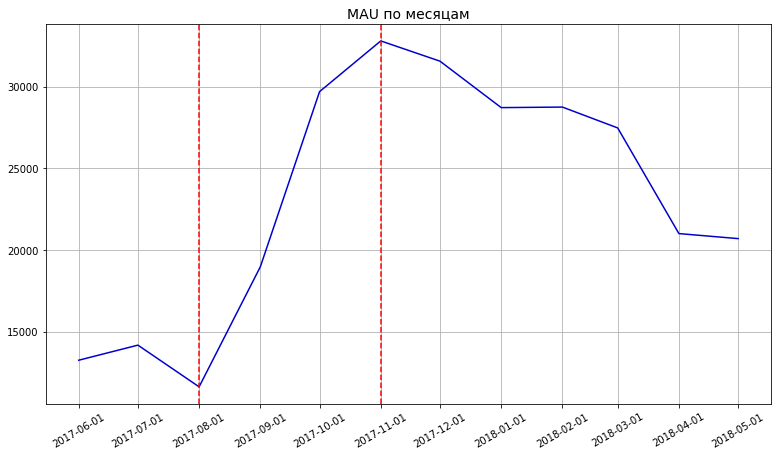

In [18]:
visits['month_session_date'] = visits['day_session'].astype('datetime64[M]')
mau_total = visits.groupby('month_session_date').agg({'uid': 'nunique'})

plt.figure(figsize=(13, 7))
plt.title('MAU по месяцам', size=14)
plt.plot(mau_total, color='#0000CC')
plt.grid()
plt.xticks(mau_total.index, rotation=30)
plt.axvline('2017-08-01', c='#F90707', ls='--')
plt.axvline('2017-11-01', c='#F90707', ls='--')
plt.show()

По графику видно, что число посетителей сайт резко начинает расти с августа по ноябрь. Можно наблюдать сезонное увеличение посетителей сайта в конце лета. Погода портится, осенью начинается театральный сезон.

<br> Выберем месяцы активного роста продаж, и проанализируем WAU.

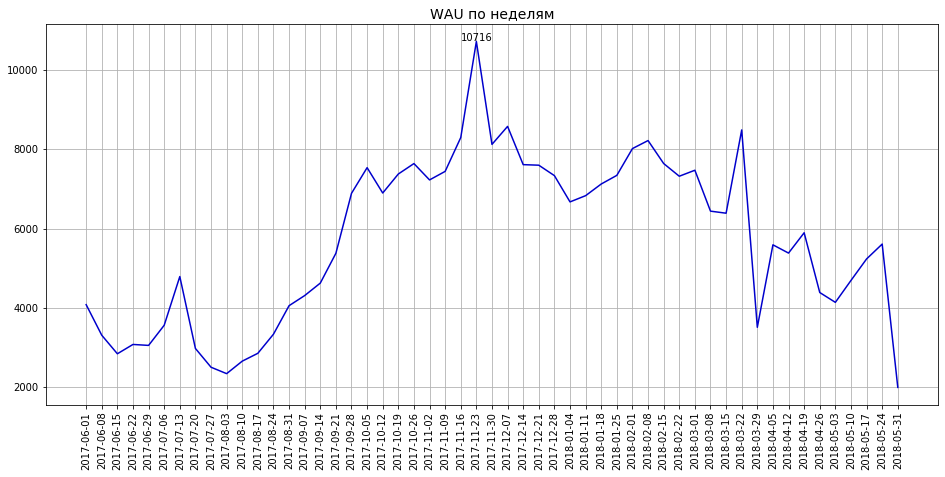

In [19]:
visits['week_session_date'] = visits['day_session'].astype('datetime64[W]')
wau_total = visits.groupby('week_session_date').agg({'uid': 'nunique'})


plt.figure(figsize=(16, 7))
plt.title('WAU по неделям', size=14)
plt.plot(wau_total, color='#0000CC')
plt.grid()
plt.xticks(wau_total.index, rotation=90)
plt.text('2017-11-16', wau_total['uid'].max(), wau_total['uid'].max());

Как и ожидалось, с начала августа до середины ноября wau в целом растет(за исключением двух недель). При этом в конце ноября резкое падение количесва новых клиентов. Дальше рост наблюдается только в январе, в период выходных и в марте. Также WAU подрастает в начале мая. Наблюдаеться увеличение количесва пользователей в недели, где есть длинные выходные.

Посмотрим, как меняется DAU в течении года и недели.

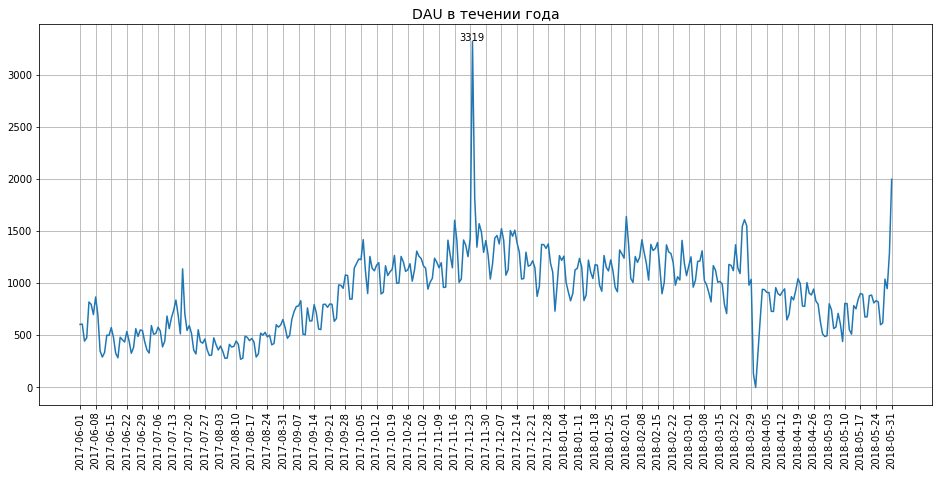

In [20]:
plt.figure(figsize=(16, 7))
plt.title('DAU в течении года', size = 14)
plt.plot(dau_total)
plt.text('2017-11-18', dau_total['uid'].max(), dau_total['uid'].max())
plt.xticks(wau_total.index, rotation=90)
plt.grid();

Даже на таком графике видно, что от недели к неделе есть закономерность в поведении пользователей. Рассмотрим любые три недели, чтобы убедиться в наличии закономерностей 
<br>Так же можно наблюдать невероятный рост dau в середине ноября до 3319.

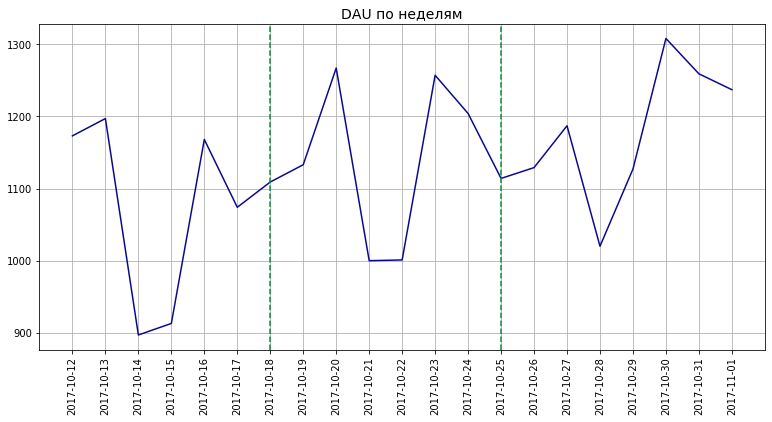

In [21]:
day_total = visits.loc[(visits['week_session_date'] >= '2017-10-12') & (visits['week_session_date'] <= '2017-10-26')]
dau_total = day_total.groupby('day_session').agg({'uid': 'nunique'})

plt.figure(figsize=(13,6))
plt.title('DAU по неделям', size=14)
plt.plot(dau_total, color='#0A088D')
plt.xticks(dau_total.index, rotation=90);
plt.grid()
plt.axvline('2017-10-18', c='#088D3E', ls='--')
plt.axvline('2017-10-25', c='#088D3E', ls='--');

Ответим на вопрос, сколько сессий проходит в день на странице Афиши и подсчитаем среднюю продолжительность сессии (ASL).

In [22]:
visits.groupby('day_session').agg({'uid': 'count'}).mean()

uid    987.362637
dtype: float64

Число сессий превышает число уникальных пользователей. Значит, некотрые люди по несколько раз за день заходят на страницу. Возможно, не могут определиться с выбором, либо покупают билеты для знакомых.
<br> Так как цели оптимизировать маркетинговые затраты, посмотрим количество пользовательскую активность в день в зависимости от рекламного источника, из которого пришел пользователь.

In [23]:
sessions_per_user = visits.groupby(['ad_source_id', 'day_session']).agg({'uid': ['nunique', 'count']})
sessions_per_user.columns = ['n_users', 'n_sessions']
sessions_per_user.reset_index(inplace = True)
sessions_per_user = sessions_per_user.groupby('ad_source_id').agg({'n_users': 'mean', 'n_sessions': 'mean'})
sessions_per_user[['n_users', 'n_sessions']] = sessions_per_user[['n_users', 'n_sessions']].astype('int')
sessions_per_user['sessions_per_day'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

(sessions_per_user
 .style
 .background_gradient(subset=['n_sessions','n_users'], cmap='Blues')
)

,n_users,n_sessions,sessions_per_day
ad_source_id,,,
1,80,93,1.1625
2,120,131,1.09167
3,232,235,1.01293
4,275,280,1.01818
5,175,184,1.05143
6,1,1,1
7,1,1,1
9,36,36,1
10,26,27,1.03846


Сразу видно, что в среднем больше всего человек призодят по 3, 4 и 5 источникам. При этом из первого источника люди чаще совершают по несколько сессий.

<br> Посмотрим, с каких каджетов заходят на наш сайт.

In [24]:
sessions_per_device = visits.groupby(['device', 'day_session']).agg({'uid': ['nunique', 'count']})
sessions_per_device.columns = ['n_users', 'n_sessions']
sessions_per_device.reset_index(inplace = True)
sessions_per_device = sessions_per_device.groupby('device').agg({'n_users': 'mean', 'n_sessions': 'mean'})
sessions_per_device[['n_users', 'n_sessions']] = sessions_per_device[['n_users', 'n_sessions']].astype('int')
sessions_per_device['sessions_per_day'] = sessions_per_device['n_sessions'] / sessions_per_device['n_users']

(sessions_per_device
 .style
 .background_gradient(subset=['n_sessions','n_users'], cmap='Blues')
)

,n_users,n_sessions,sessions_per_day
device,,,
desktop,659,721,1.09408
touch,252,266,1.05556


По таблице видно, что в основном на сайт афиши люди переходят с настольного компьютера.

<br> Посчитаем, сколько в среднем длится одна сессия.

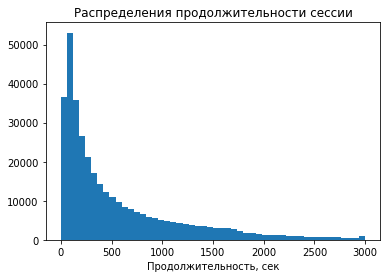

In [25]:
visits['visits_duration_sec'] = (visits['session_end_ts'] - visits['session_start_ts']).dt.seconds

#построим гистограмму для оценки распределения
plt.figure()
plt.title('Распределения продолжительности сессии')
plt.hist(visits['visits_duration_sec'], bins = 50, range=(0, 3000))
plt.xlabel('Продолжительность, сек');

In [26]:
asl = float(visits['visits_duration_sec'].mode())
print(f'ASL = {asl}')

ASL = 60.0


Посмотрим, как выглядят распределения для разных рекламных источников

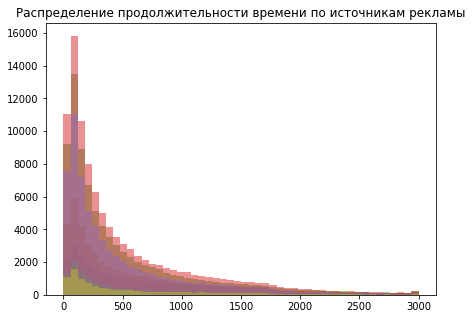

In [27]:
plt.figure(figsize=(7, 5))
plt.title('Распределение продолжительности времени по источникам рекламы')
for sour in sorted(visits['ad_source_id'].unique()):
    sour_visit = visits.loc[visits['ad_source_id'] == sour, 'visits_duration_sec']
    plt.hist(sour_visit, bins = 50, range =(0, 3000), alpha=0.5)

Для всех источников рекламы, распределение времени на отрезке от 0 до 3000 похожже на среднее распределение, и может описываться модой. посчитаем численное значения для каждого источника рекламы.

In [28]:
for sours in visits['ad_source_id'].unique():
    try:
        asl = visits.loc[visits['ad_source_id'] == sours, 'visits_duration_sec'].mode()
        print('ASL для {0} = {1}'.format(sours, int(asl)))
    except:
        asl = 'нет моды'
        print('ASL для {0} = {1}'.format(sours, asl))

ASL для 4 = 60
ASL для 2 = 60
ASL для 5 = 60
ASL для 9 = 60
ASL для 3 = 60
ASL для 1 = 60
ASL для 10 = 60
ASL для 7 = 120
ASL для 6 = нет моды


Дольше всего пользуются сайтом пользователи, которых привлек источник номер 1. Также большую продолжительность времени имеют источники 2 и 6.
<br> Посмотрим, меняется ли время сесиси от девайса.

In [29]:
for device in visits['device'].unique():
    asl = visits.loc[visits['device'] == device, 'visits_duration_sec'].mode()
    print('ASL для {0} = {1}'.format(device, int(asl)))

ASL для touch = 60
ASL для desktop = 60


Независимо от устройсва, больше всего людей пользуются сервисом минуту.

Для ответа на вопрос, как часто люди возвращаются, нам необходимо подсчитать Retention Rate (коэффициент удержания). Подсчет коэффициента будем производить на основе когортного анализа.
<br> Построим коготы периодном в 1 месяц.

In [30]:
first_session_date = visits.groupby('uid')['session_start_ts'].min()
first_session_date.name = 'first_session_date'
visits = visits.join(first_session_date, on='uid')

In [31]:
#посчитаем время жизни когорты
visits['session_date_month'] = visits['first_session_date'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['session_start_ts'] - visits['first_session_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits['cohort_lifetime'].head()

0    0
1    0
2    0
3    2
4    0
Name: cohort_lifetime, dtype: int64

Сгруппируем данные по когорте и lifetime. Подсчитаем количесвто пользователей в каждом месяце и в 0 недели жизни. На основе этих данных подсчитаем Retention Rate и выведем в виде heat map.

In [32]:
cohorts = visits.groupby(['session_date_month','cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
#пользователей на 0 недели
initial_count = cohorts.loc[cohorts['cohort_lifetime'] == 0][['session_date_month', 'uid']]
initial_count.rename(columns={'uid': 'cohort_users'}, inplace = True)
cohorts = cohorts.merge(initial_count, on='session_date_month', how='left')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index=['session_date_month'],columns='cohort_lifetime',values='retention',aggfunc='sum') 

In [33]:
#посторение тепловых карт
def heatmap(data, vmin=0, vmax=1, title='Heatmap', fmt='.1%'):
    plt.figure(figsize=(13, 9))
    sns.set(style='white')
    plt.title(title, size = 14)
    sns.heatmap(data, annot=True, fmt=fmt, linewidths=1, linecolor='gray', vmin=vmin, vmax=vmax, cmap= 'coolwarm', yticklabels=data.index.strftime('%Y-%m'))
    plt.xlabel('Время жизни когорты')
    plt.ylabel('Месяц первой сессии')
    plt.show()

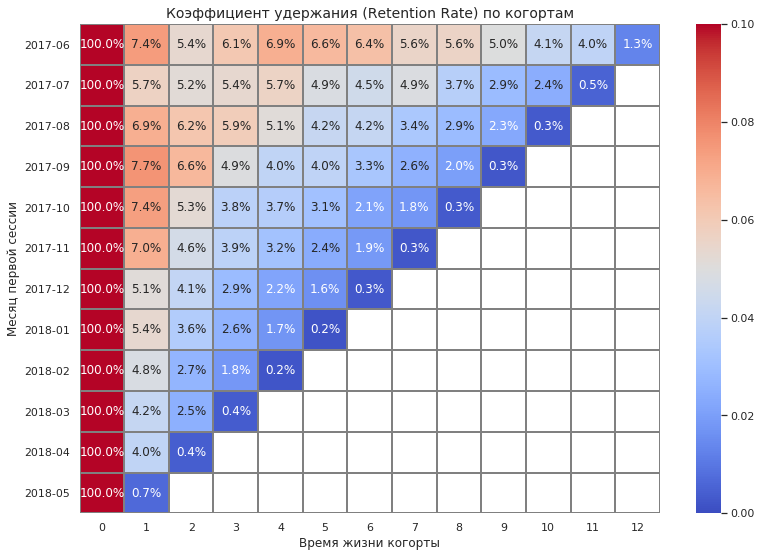

In [34]:
heatmap(retention_pivot, vmin=0, vmax=0.1, title='Коэффициент удержания (Retention Rate) по когортам')

### Вывод

### Метрики продаж <a id='step3_2'></a>

Когда люди начинают покупать. Для ответа на этот вопрос подсчитаем, сколько проходит времени с первого посещещения сайта до певой покупки.
<br>найдем дату первого посещения и дату первой покупки для каждого клиента и соединим эти таблицы.

In [35]:
first_visits = visits.groupby('uid')['session_start_ts'].min()
first_visits.name = 'first_visits'
first_orders = orders.groupby('uid')['order_date'].min().reset_index()
first_orders.name = 'first_orders'
first_orders = first_orders.join(first_visits, on = 'uid')
first_orders['order_duration'] = (first_orders['order_date'] - first_orders['first_visits']) / np.timedelta64(1, 'm') #перервод в минуты
first_orders.head()

,uid,order_date,first_visits,order_duration
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0


In [36]:
first_orders['order_duration'].describe()

count     36523.000000
mean      24340.175834
std       67784.774690
min           0.000000
25%           4.000000
50%          16.000000
75%        2897.000000
max      523144.000000
Name: order_duration, dtype: float64

По описанию видно, что данные распределены не нормально и имеют положительную ассиметрию. Чтобы в этом убедиться построим гистограмму распределения.

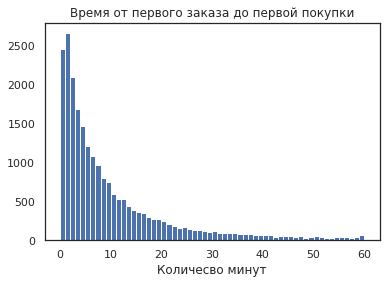

In [37]:
plt.figure()
plt.hist(first_orders['order_duration'], bins = 60, range=(0,  60))
plt.title('Время от первого заказа до первой покупки')
plt.xlabel('Количесво минут')
plt.show()

Для того, что бы ответить сколько раз покупают за период, подсчитаем конверсию в покупку. При этом всех пользователей разделим на когорты.

In [38]:
first_orders = orders.groupby('uid')['order_date'].min()
first_orders.name = 'first_orders'
orders = orders.join(first_orders, on='uid')

In [39]:
orders['first_orders_month'] = orders['first_orders'].astype('datetime64[M]')
orders['cohort_lifetime'] = (orders['order_date'] - orders['first_orders']) / np.timedelta64(1, 'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].astype('int')
orders.head()

,order_date,revenue,uid,first_orders,first_orders_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,0


Найдем количесво покупок в каждой когорте и после посчитаем конверсию в покупку.

In [40]:
count_orders = orders.groupby(['first_orders_month', 'cohort_lifetime']).agg({'order_date': 'count'})
count_orders.rename(columns={'order_date': 'orders_count'}, inplace=True)
cohorts.rename(columns={'session_date_month': 'first_orders_month', 'uid': 'n_users'}, inplace=True)
count_orders = count_orders.merge(cohorts, on = ['first_orders_month', 'cohort_lifetime'])
count_orders
#подсчитаем конверсию в покупку
count_orders['conversion'] = count_orders['orders_count'] / count_orders['n_users']
count_orders.head()

,first_orders_month,cohort_lifetime,orders_count,n_users,cohort_users,retention,conversion
0,2017-06-01,0,2417,13259,13259,1.000000,0.182291
1,2017-06-01,1,155,986,13259,0.074365,0.157201
2,2017-06-01,2,171,710,13259,0.053549,0.240845
3,2017-06-01,3,276,813,13259,0.061317,0.339483
4,2017-06-01,4,263,921,13259,0.069462,0.285559


In [41]:
cohorts_conversion = count_orders.pivot_table(index = 'first_orders_month', 
                                              columns = 'cohort_lifetime', 
                                              values = 'conversion',
                                             aggfunc = 'sum')

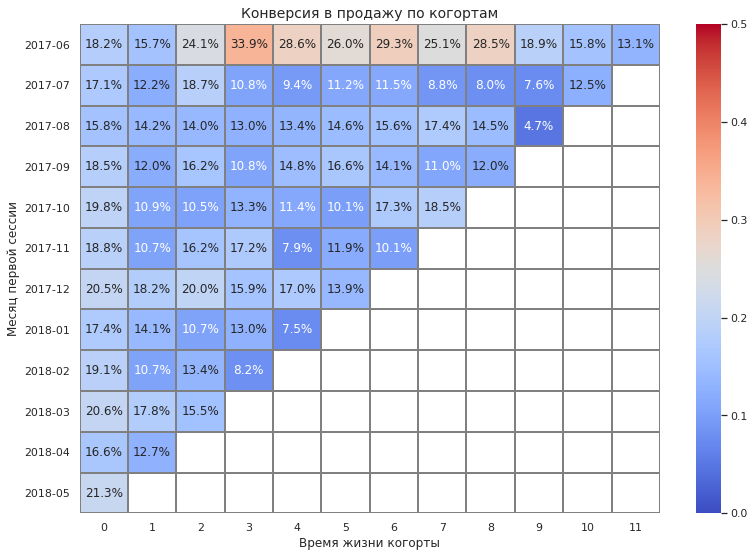

In [42]:
heatmap(cohorts_conversion, vmin=0, vmax=0.5, title ='Конверсия в продажу по когортам')

Коэффициент конверсии в первом месяце меняется в каждой новой когорте и в целом по времени жизни. Коэффициент конверсии в первый месяц варьируется от 15.8 до 21.3%. В целом по месяцам жизни когорты видна тенденция на спад конверсии, но в первой когорте наблюдается активность оставшихся клиентов, и конверсия возрастает до 33,9%. Именно в этот период, мы видели возвращение клоиентов. Возможно рост конверсии связан с персональными предложениями. Рост количесва покупок виден и в предпраздничные праздничные месяцы. Например в декабре и марте. Предполагаю, что люди охотно дарят близким билеты.

Есть ли отличия в конверсии для пользователей, пришедщих из разных источников. Посчитаем конверсию за весь период. Для добавим в таблицу *cohorts_conversion* информацию о рекламных источниках и девайсах. Предполагаем, что день окончания сессии совпадает с днем покупки. Будем использовать эти столбцы для соединения таблиц.

In [43]:
orders['day_session'] = orders['order_date'].astype('datetime64[D]')
orders_full = orders.merge(visits[['uid', 'day_session', 'ad_source_id', 'device']], on=['uid', 'day_session'])
orders_full.head()

,order_date,revenue,uid,first_orders,first_orders_month,cohort_lifetime,day_session,ad_source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,0,2017-06-01,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,0,2017-06-01,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,0,2017-06-01,3,desktop


In [44]:
visits_count = visits.groupby('ad_source_id')['uid'].nunique().reset_index()
visits_count.rename(columns={'uid': 'visits_count'}, inplace = True)
orders_count = orders_full.groupby('ad_source_id')['uid'].nunique().reset_index()
visits_count = visits_count.merge(orders_count, on='ad_source_id')
visits_count['conversion'] = visits_count['uid'] / visits_count['visits_count']
(visits_count[['ad_source_id', 'conversion']]
 .style
 .background_gradient(subset=['conversion'], cmap='Blues')
)

,ad_source_id,conversion
0,1,0.274699
1,2,0.174929
2,3,0.120325
3,4,0.116157
4,5,0.129726
5,7,0.0294118
6,9,0.102332
7,10,0.156688


Самая высокая средняя конверсия у рекламных источников под номером 1, 2 и 10 источника рекламы.

<br> Посмотрим, сколько в среднем люди тратят денег на нашем сервисе. Подсчитаем средний чек по каждой когорте.

In [45]:
average_check = orders.pivot_table(index = 'first_orders_month',
                                  columns = 'cohort_lifetime', 
                                  values = 'revenue', 
                                   aggfunc = 'mean')

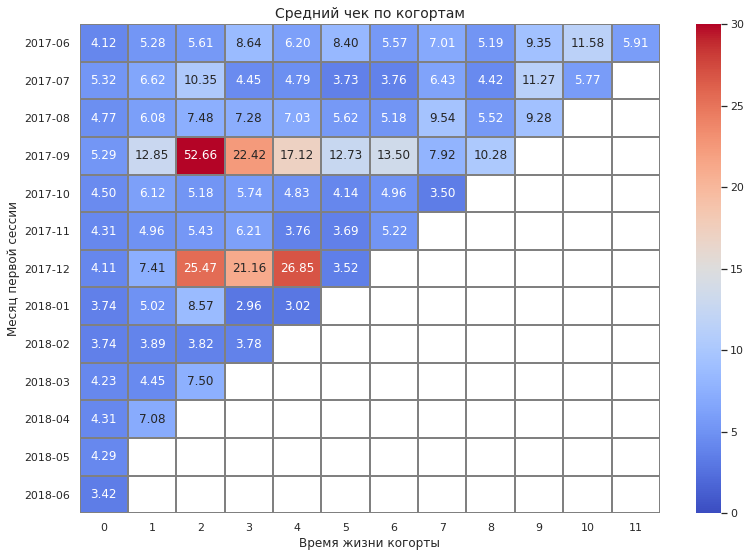

In [46]:
heatmap(average_check, vmin=0, vmax=30, title ='Средний чек по когортам', fmt='.2f')

Средний чек лишь немного меняется из когорту в когорту в первом месяце. После для всех когорт характепен рост чека несколько месяцев и дальнейший спад. В когорте от 09-2017 аномально высокие значения на 2 месяце жизни. Посмотрим на эти данные.

In [47]:
orders.query('first_orders_month == "2017-09-01" and cohort_lifetime == 2')['revenue'].describe()

count     180.000000
mean       52.656333
std       226.550837
min         0.030000
25%         1.040000
50%         3.780000
75%        21.085000
max      2633.280000
Name: revenue, dtype: float64

Имеется очень большой заказ. Посомотрим на него.

In [48]:
orders.query('revenue == 2633.28')

,order_date,revenue,uid,first_orders,first_orders_month,cohort_lifetime,day_session
23244,2017-12-10 20:17:00,2633.28,5539673724080479777,2017-09-20 19:55:00,2017-09-01,2,2017-12-10


Хоть данная сумма выбивается из общей массы, может быть это крупный корпоративный клиент покупал билеты перед Новогодними праздниками.

<br> Посмотрим, различается ли чек у людей из разных источников.

In [49]:
orders_full.pivot_table(index='ad_source_id', values='revenue').style\
.background_gradient(subset=['revenue'], cmap='Blues')

,revenue
ad_source_id,
1,6.36681
2,7.88252
3,4.07475
4,4.11191
5,4.93514
7,1.22
9,3.22272
10,2.92153


В среднем, самый большой средний чек у людей, перешедших из рекламного источника 1 и 2. Посмотрим, как этот средний чек распределен по когортам для этих двух источников рекламы.

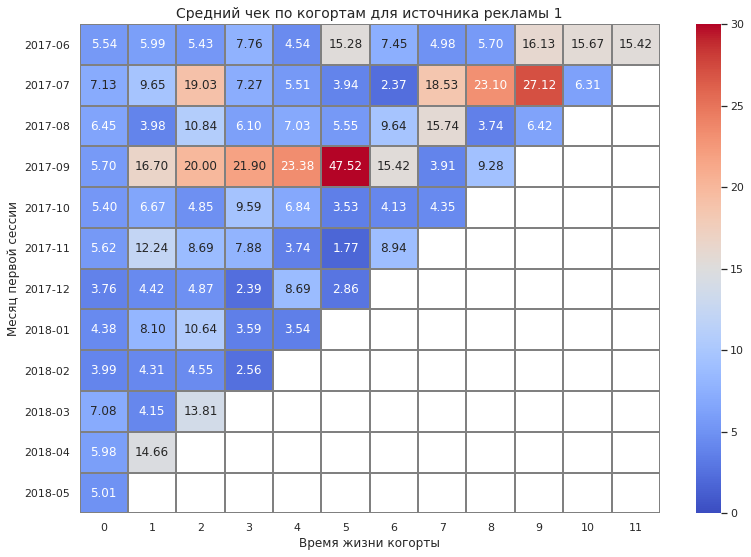

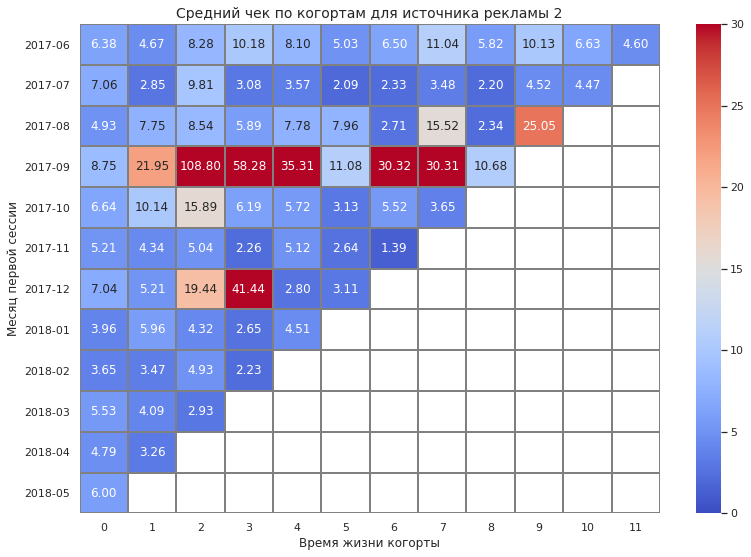

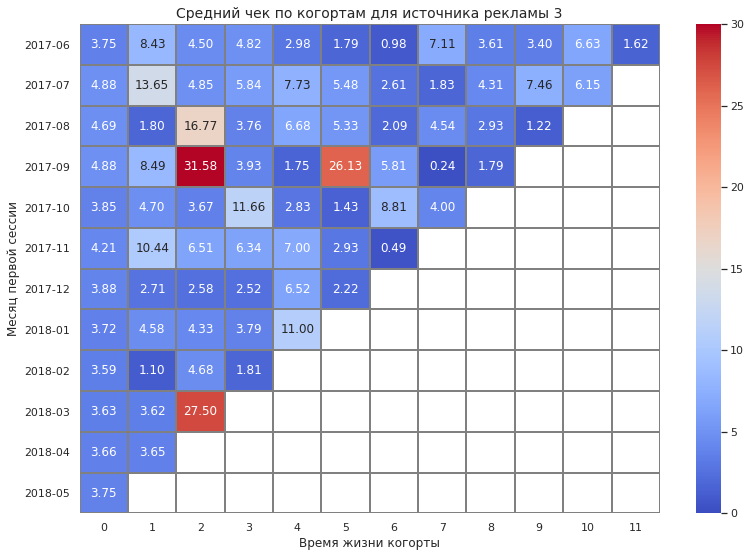

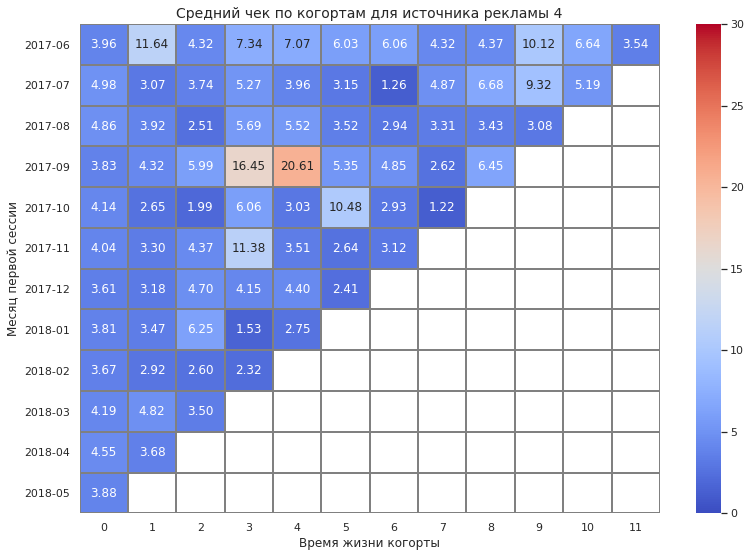

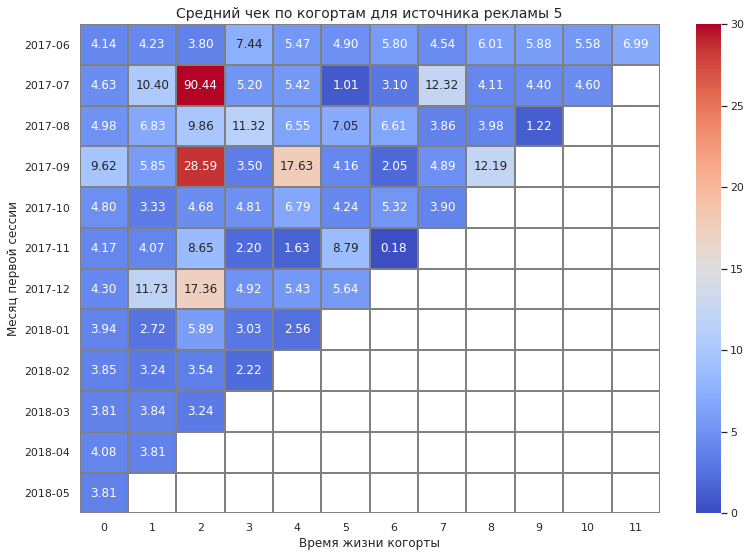

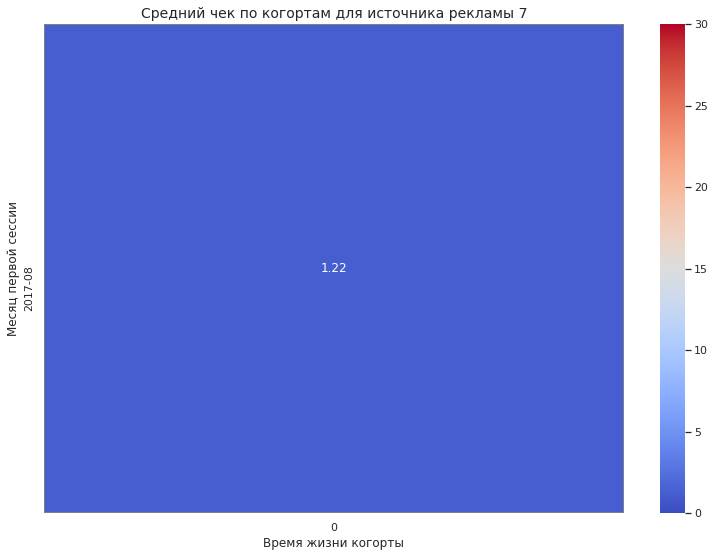

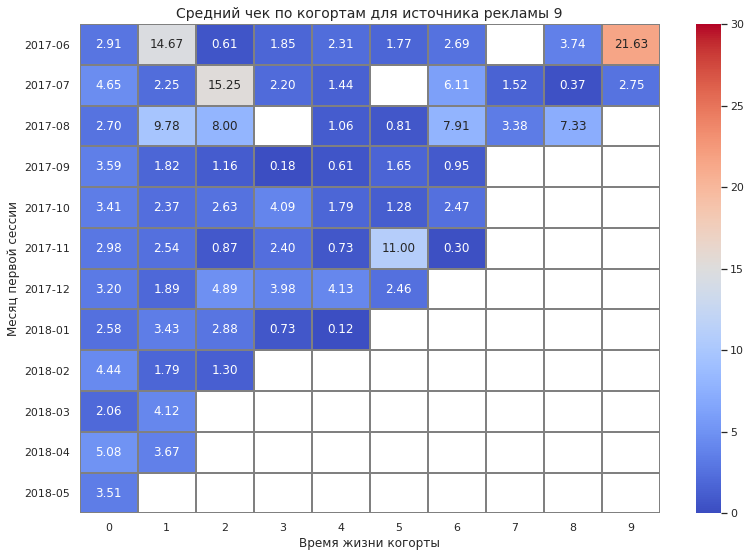

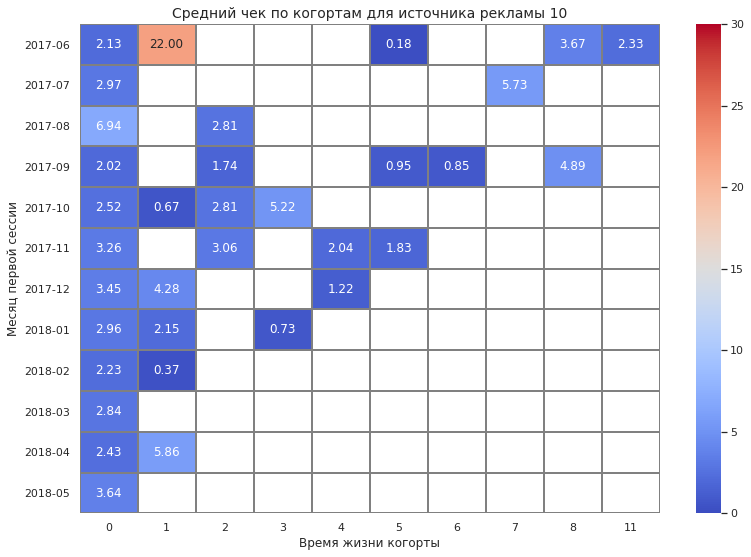

In [50]:
source = [1, 2, 3, 4, 5, 7, 9, 10]
for i in source:
    average_check = orders_full.loc[orders_full['ad_source_id'] == i].pivot_table(index = 'first_orders_month', 
                                                                                  columns = 'cohort_lifetime', 
                                                                                  values = 'revenue', 
                                                                                  aggfunc = 'mean')
    heatmap(average_check, vmin=0, vmax=30, title ='Средний чек по когортам для источника рекламы {}'.format(i), fmt='.2f')  

Проанализируем, как меняется средний чек пользователей по месяцам. 

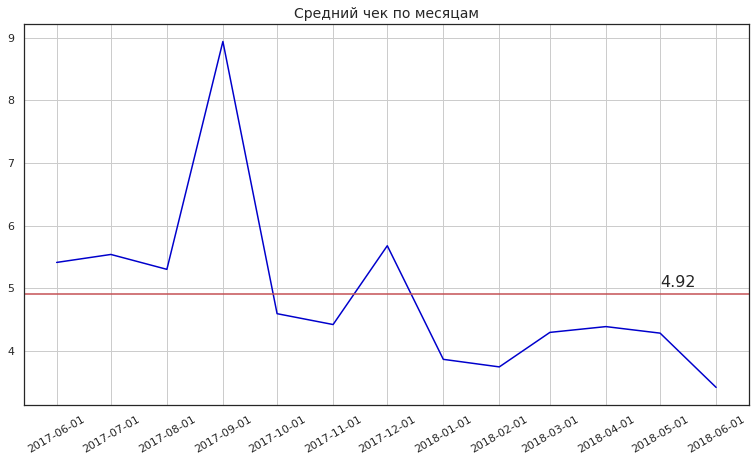

In [51]:
average_month = orders.groupby('first_orders_month').agg({'revenue': 'mean'})

plt.figure(figsize=(13, 7))
plt.title('Средний чек по месяцам', size=14)
plt.plot(average_month, color='#0000CC')
plt.grid()
plt.xticks(average_month.index, rotation=30)
plt.axhline(average_month['revenue'].mean(), color='r');
plt.text('2018-05-01', average_month['revenue'].mean() + 0.1, average_month['revenue'].mean().round(2), size=16);

Максимум по среднему чеку в сентябре, потом мы видим сразу резкое уменишение этого покателя. В среднем средний чек  за год составляет 4,92.

Подсчитаем, сколько денег нам приносит каждый клиент. Для этого воспользаемся LTV.

In [52]:
orders.head()

,order_date,revenue,uid,first_orders,first_orders_month,cohort_lifetime,day_session
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,0,2017-06-01


In [53]:
#количесвто новых покупателей в каждом месяце
cohort_sizes = orders.groupby('first_orders_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_orders_month', 'n_buyers']
cohort_sizes

,first_orders_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [54]:
#выручка по когортам
cohort = orders.groupby(['first_orders_month', 'cohort_lifetime'])['revenue'].sum().reset_index()
report_full = cohort_sizes.merge(cohort, on = 'first_orders_month')
report_full.head()

,first_orders_month,n_buyers,cohort_lifetime,revenue
0,2017-06-01,2023,0,9947.04
1,2017-06-01,2023,1,818.92
2,2017-06-01,2023,2,958.89
3,2017-06-01,2023,3,2384.39
4,2017-06-01,2023,4,1629.82


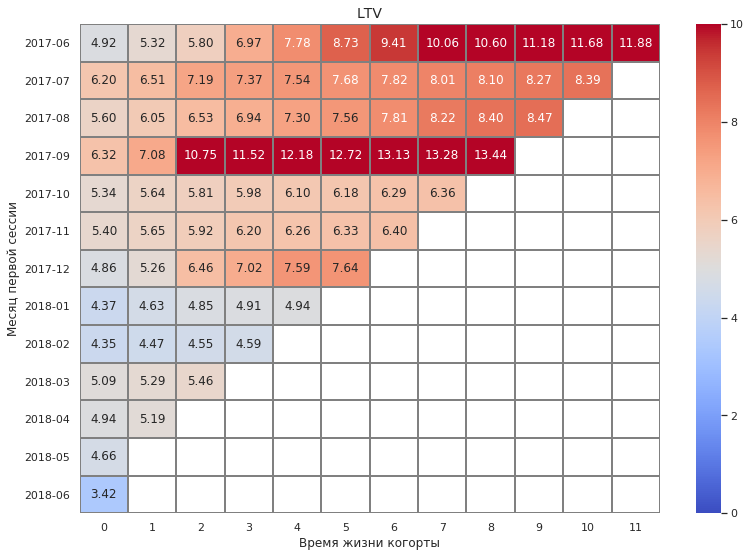

In [55]:
report_full['ltv'] = report_full['revenue'] / report_full['n_buyers']
report_pivot = report_full.pivot_table(index='first_orders_month',
                           columns='cohort_lifetime',
                           values='ltv',
                           aggfunc='mean')
heatmap(report_pivot.cumsum(axis=1), vmin=0, vmax=10, title ='LTV', fmt='.2f')

По графику видно, что большое количество пользователей покупают много покупают у нас в первый месяц, и после покупают намного меньше. Подсчитаем итоговый LTV первой когорты.

В среднем каждый покупатель за год жизни когорты приносит нам **11.88**

Посмотрим, меняется ли LTV в зависимости от рекламного источника, из которого пришел клиент. Подсчитаем итоговый LTV по первой когорте для каждого источника.

In [56]:
orders_full.head()

,order_date,revenue,uid,first_orders,first_orders_month,cohort_lifetime,day_session,ad_source_id,device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,0,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0,2017-06-01,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,0,2017-06-01,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,0,2017-06-01,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,0,2017-06-01,3,desktop


In [57]:
orders_count_sourse = orders_full.groupby(['first_orders_month', 'ad_source_id']).agg({'uid': 'nunique'}).reset_index()
revenue_sourse = orders_full.groupby(['first_orders_month', 'cohort_lifetime', 'ad_source_id']).agg({'revenue': 'sum'}).reset_index()
revenue_sourse = revenue_sourse.merge(orders_count_sourse, on = ['first_orders_month', 'ad_source_id'])
revenue_sourse['ltv'] = revenue_sourse['revenue'] / revenue_sourse['uid']
#отберем только первую когорту
revenue_sourse_first = revenue_sourse.loc[revenue_sourse['first_orders_month'] == '2017-06-01']
report = revenue_sourse_first.pivot_table(index = 'ad_source_id', values='ltv', aggfunc = 'sum')
report.style\
.background_gradient(subset=['ltv'], cmap='Blues')

,ltv
ad_source_id,
1,34.4465
2,25.6317
3,4.45428
4,6.9123
5,14.1611
9,5.65791
10,2.76535


По первой когорте видно, что покупатели, перешедшие из первого и второго источника покупают больше. Также довольно много тратят люди, перешедшие из 5 источника. Люди, ктьо пришел из 3 и 4 тратят не так много денег, несмотря на самый большой охват именно этой рекламы.
<br> Посмотрим, на LTV в этих 5 источниках по всем когортам.

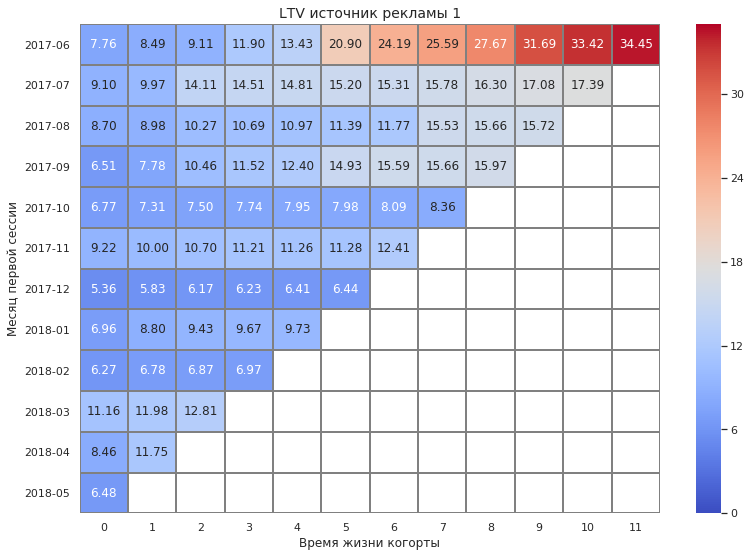

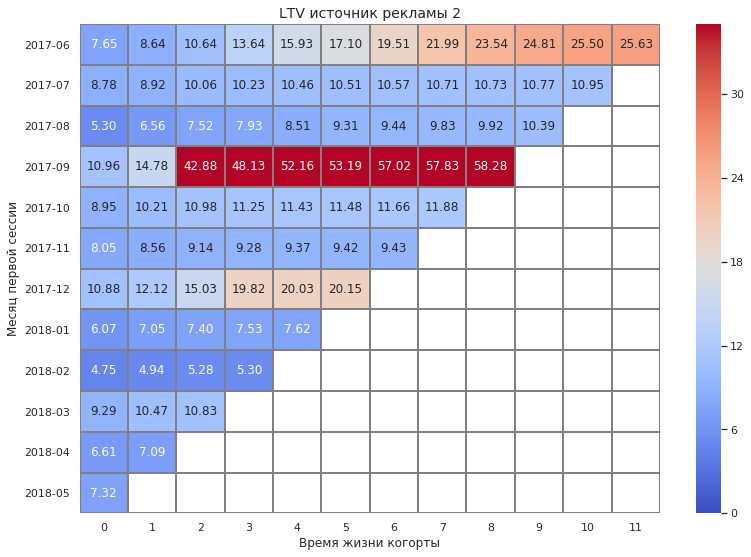

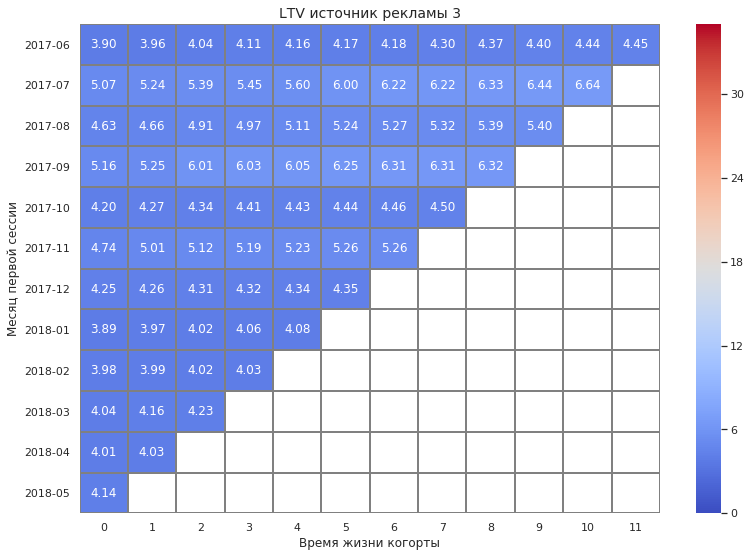

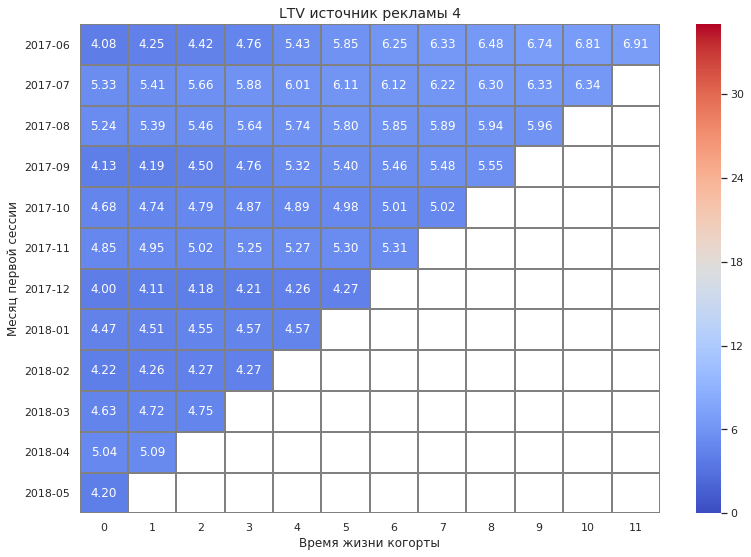

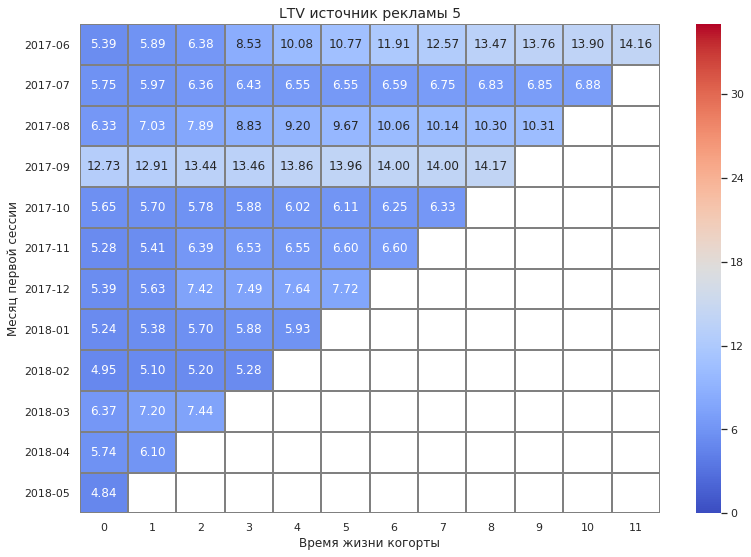

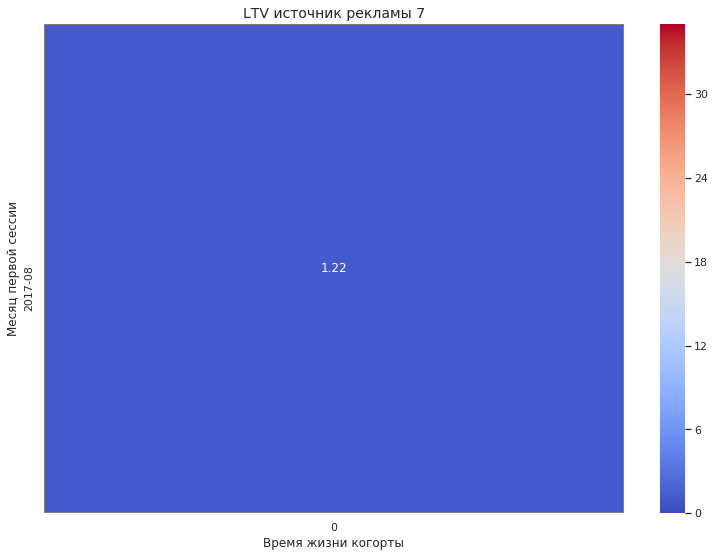

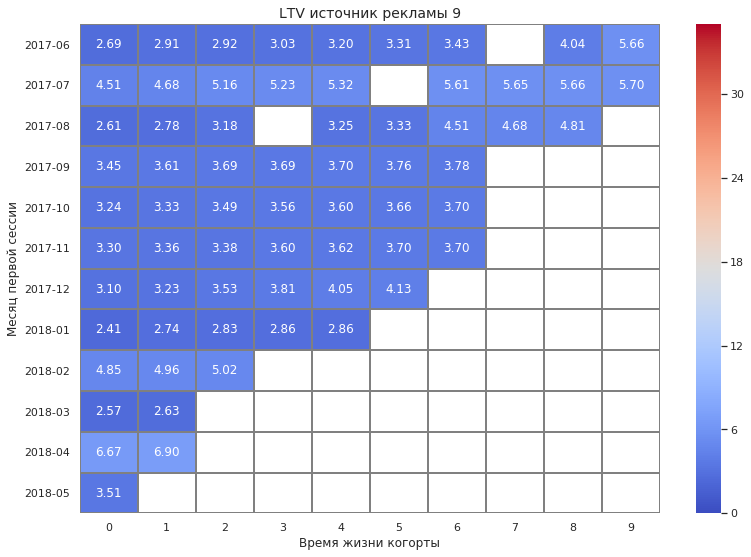

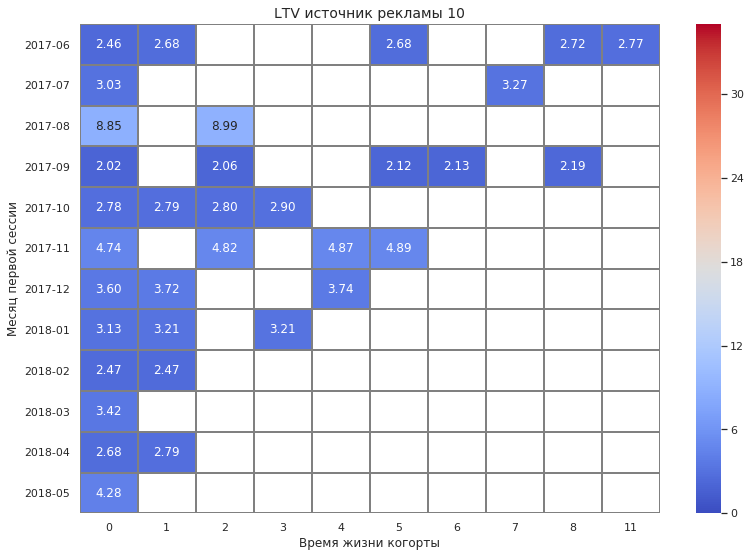

In [58]:
source = [1, 2, 3, 4, 5, 7, 9, 10]
for i in source:
    ltv_source = revenue_sourse.loc[revenue_sourse['ad_source_id'] == i]
    report = ltv_source.pivot_table(index='first_orders_month',
                           columns='cohort_lifetime',
                           values='ltv',
                           aggfunc='mean')
    heatmap(report.cumsum(axis=1), vmin=0, vmax=35, title ='LTV источник рекламы {}'.format(i), fmt='.2f')

### Вывод

Рассмотрели основные продуктовые метрики.
* В среднем, для покупки людям требуется меньше 16 минут.
* Коэффициент конверсии в первом месяце меняется в пределах от 15.8 до 21.3%.. В целом по времени жизни когорты наблюдается спад конверсии, но в первой когорте осенью коэффициент растет до 33,9%. Возможно, рост конверсии связан с персональными предложениями. Рост количесва покупок виден и в предпраздничные праздничные месяцы. Например в декабре и марте. Предполагаю, что люди охотно дарят близким билеты. Конверсия различается по рекламным источникам. Наибольшая метрика для источника 1 и 2.
* Средний чек лишь немного меняется из когорту в когорту в первом месяце. После для всех кагорт характерен рост чека несколько месяцев и дальнейший спад. На графиках есть анамально высокие значения среднего чека в предпраздничные месяца. Может это корпоративный клиент. В среднем, самые большие средние чеки приносят люди из 1 и 2 рекламного источника, особенно активно пользается спросом когорта 2017-09. 
* Подсчитали LTV для каждой когорты. Большинство пользователей покупают у нас в первый месяц, а позже приносят все меньше денег. Итоговый LTV по первой когорте 11.88. Больше всего денег приносят пользователи, которые пришли к нам из 1 и 2 рекламного источника.

### Маркетинговые метрики <a id='step3_3'></a>

В этом пункте рассмотрим, сколько денег было потрачено на рекламу. Подсчитаем, сколько было потрачено на рекламу в течении года на каждый рекламный источник.

In [59]:
costs.head()

,ad_source_id,ad_date,costs_per_day
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [60]:
total_cost = costs['costs_per_day'].sum()
print(f'Всего потрачено на рекламу {total_cost}')

Всего потрачено на рекламу 329131.62


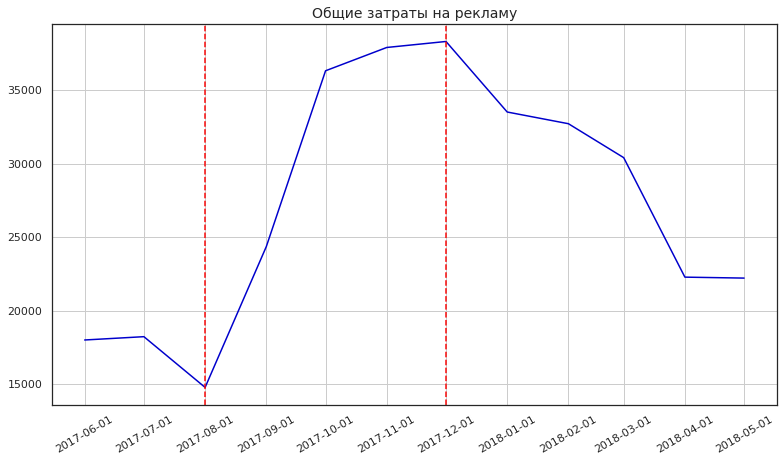

In [61]:
costs['ad_date_month'] = costs['ad_date'].astype('datetime64[M]')
cost_month = costs.groupby('ad_date_month')['costs_per_day'].sum()

plt.figure(figsize=(13, 7))
plt.title('Общие затраты на рекламу', size=14)
plt.plot(cost_month, color='#0000CC')
plt.grid()
plt.xticks(cost_month.index, rotation=30)
plt.axvline('2017-08-01', c='#F90707', ls='--')
plt.axvline('2017-12-01', c='#F90707', ls='--')
plt.show()

По графику видно, что с августа 2017 наблюдается резкий подъем вложений в рекламу. Пик достигается в декабре 2017 и дальше вложения падают. Это период активной подготовки к новогодним праздникам. Скорее всего, именно эти вложения повысили показатели продаж в этот период.

<br> Посмотрим, как изменялись вложения в рекламу для разных источников.

In [62]:
cost_month_sourse = costs.groupby(['ad_source_id', 'ad_date_month'])['costs_per_day'].sum().reset_index()
cost_month_sourse.head()

,ad_source_id,ad_date_month,costs_per_day
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


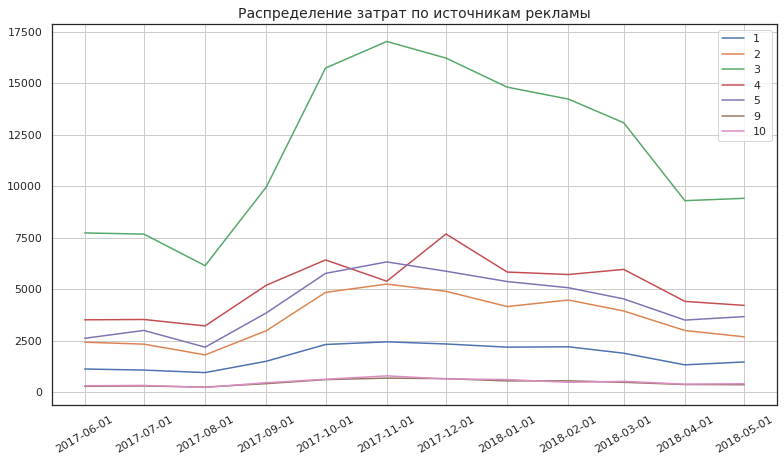

In [63]:
source = cost_month_sourse['ad_source_id'].unique().tolist()
plt.figure(figsize = (13, 7))
plt.title('Распределение затрат по источникам рекламы', size = 14)
for i in source:
    cost_month = cost_month_sourse.loc[cost_month_sourse['ad_source_id'] == i]
    plt.plot(cost_month['ad_date_month'],
            cost_month['costs_per_day'],
            label = i)
    plt.legend(source)
plt.grid();
plt.xticks(cost_month_sourse['ad_date_month'].unique(), rotation=30);

In [64]:
orders_count_sourse.head()

,first_orders_month,ad_source_id,uid
0,2017-06-01,1,317
1,2017-06-01,2,326
2,2017-06-01,3,656
3,2017-06-01,4,460
4,2017-06-01,5,448


In [65]:
cost_month_sourse.rename(columns={'ad_date_month': 'first_orders_month'}, inplace=True)
report_new = cost_month_sourse.merge(orders_count_sourse, on = ['first_orders_month', 'ad_source_id'])
report_new['cac'] = report_new['costs_per_day'] / report_new['uid']

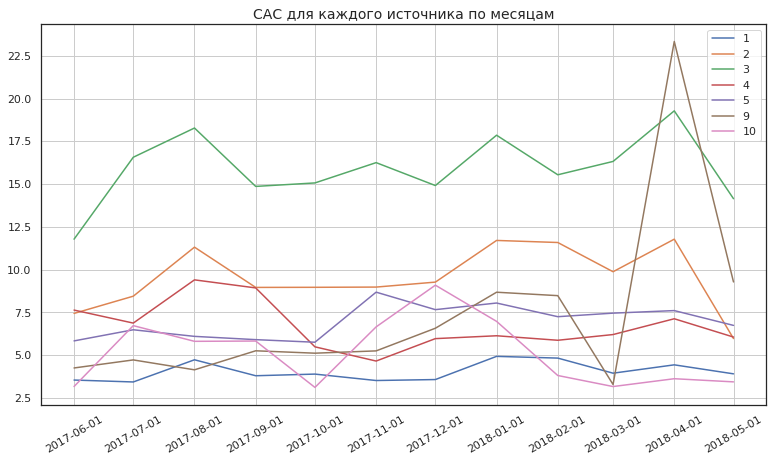

In [66]:
plt.figure(figsize = (13, 7))
plt.title('CAC для каждого источника по месяцам', size = 14)
for i in source:
    report = report_new.loc[report_new['ad_source_id'] == i]
    plt.plot(report['first_orders_month'],
            report['cac'],
            label = i)
    plt.legend(source)
plt.grid();
plt.xticks(report_new['first_orders_month'].unique(), rotation=30);

In [67]:
#средний показатель сас
report_new.groupby('ad_source_id')['cac'].mean().sort_values(ascending=False)

ad_source_id
3     15.913167
2      9.530598
9      7.369922
5      6.965830
4      6.701326
10     5.122316
1      4.050336
Name: cac, dtype: float64

In [68]:
report_new.query('ad_source_id == 9 and first_orders_month == "2018-04-01"')

,ad_source_id,first_orders_month,costs_per_day,uid,cac
70,9,2018-04-01,373.49,16,23.343125


Подсчитам, насколько у нас окупаются расходы на рекламу.

In [69]:
romi_source = revenue_sourse.merge(report_new, on=['ad_source_id', 'first_orders_month'])
romi_source['romi'] = romi_source['ltv'] / romi_source['cac'] 

In [70]:
romi_source

,first_orders_month,cohort_lifetime,ad_source_id,revenue,uid_x,ltv,costs_per_day,uid_y,cac,romi
0,2017-06-01,0,1,2458.51,317,7.755552,1125.61,317,3.550820,2.184158
1,2017-06-01,1,1,233.54,317,0.736719,1125.61,317,3.550820,0.207479
2,2017-06-01,2,1,195.58,317,0.616972,1125.61,317,3.550820,0.173755
3,2017-06-01,3,1,884.33,317,2.789685,1125.61,317,3.550820,0.785645
4,2017-06-01,4,1,485.45,317,1.531388,1125.61,317,3.550820,0.431277
...,...,...,...,...,...,...,...,...,...,...
485,2018-05-01,0,3,2754.39,665,4.141940,9411.42,665,14.152511,0.292665
486,2018-05-01,0,4,2916.27,695,4.196072,4214.21,695,6.063612,0.692009
487,2018-05-01,0,5,2635.02,544,4.843787,3669.56,544,6.745515,0.718075
488,2018-05-01,0,9,136.76,39,3.506667,362.17,39,9.286410,0.377613


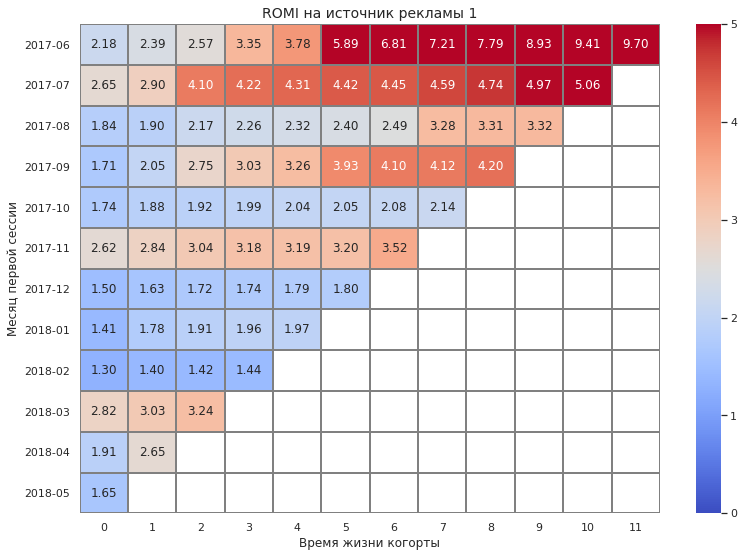

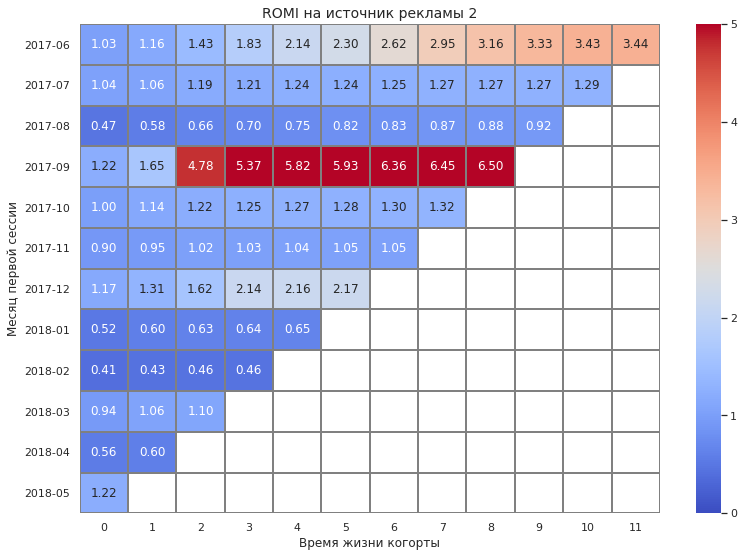

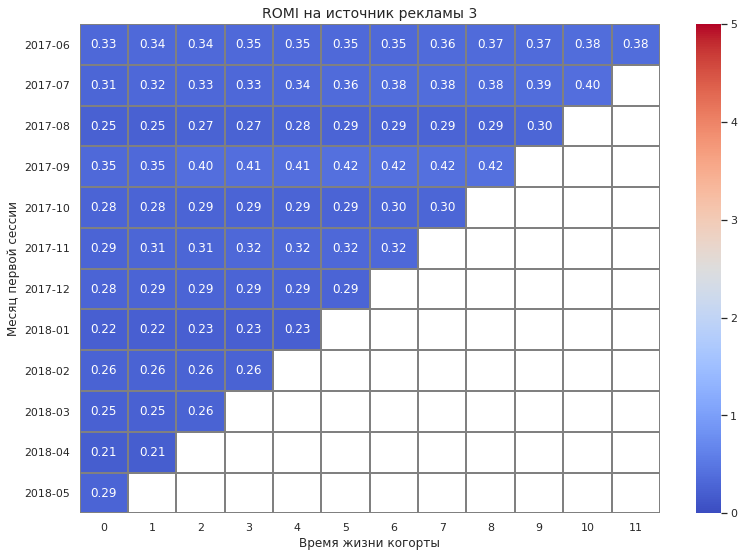

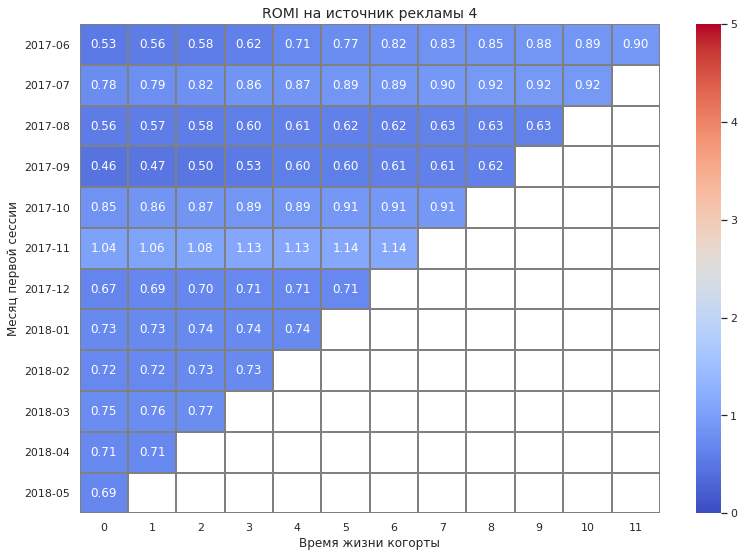

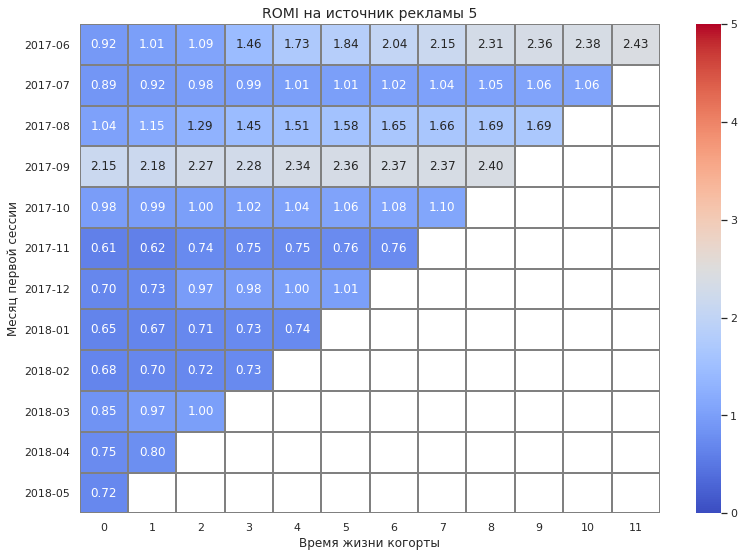

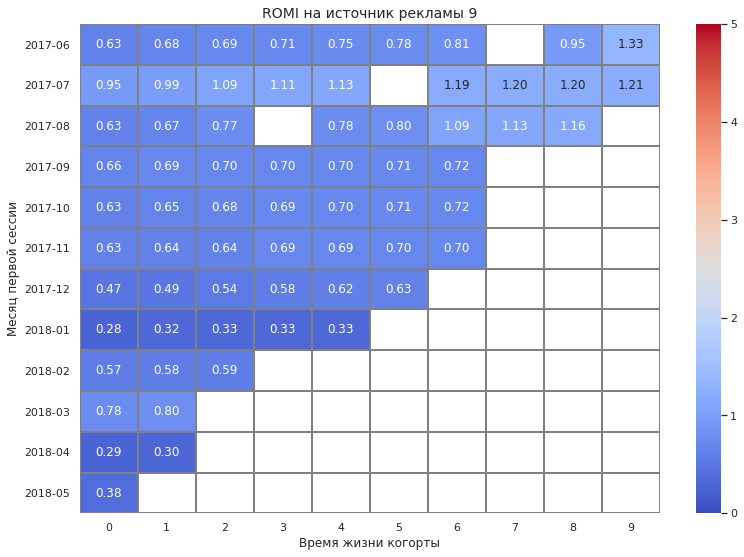

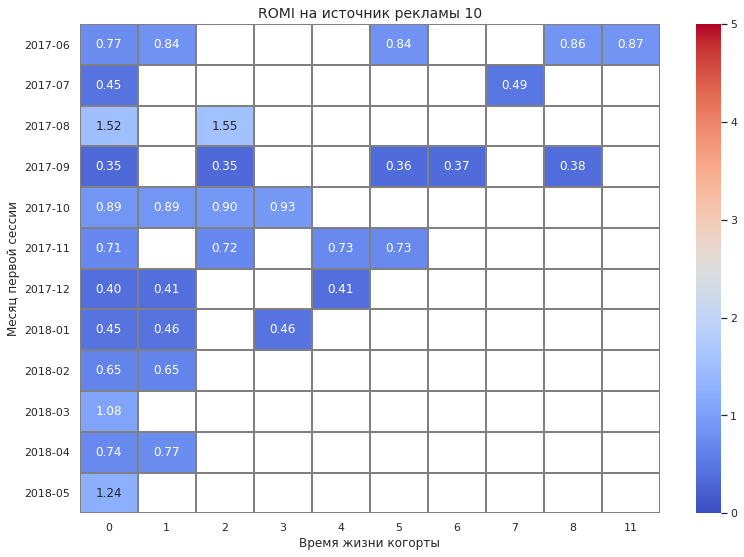

In [78]:
for i in source:
    romi_source_ad = romi_source.loc[romi_source['ad_source_id'] == i]
    report_romi =  romi_source_ad.pivot_table(index='first_orders_month', 
                                              columns='cohort_lifetime', 
                                              values='romi', 
                                              aggfunc='mean')
    report_romi = report_romi.cumsum(axis=1).round(2) #накопительный romi
    heatmap(report_romi , vmin=0, vmax=5, title ='ROMI на источник рекламы {}'.format(i), fmt='.2f')

Из тепловых карт видно, что первый рекламный источник окупается сразу в месяц запуска когорты, при этом имеет сразу коэффициент возврата больше 2. Второй источник так же быстро окупаемый. В среднем для когорт на втрой месяц. Также на второй месяц окупается 4 и 5 рекламный источники. Окупаемость третьего происходит только на 4 месяц.


### Вывод

В этом шаге выячнили, что рост затрат на маркетинг приходится на перриод с августа до декабря. Скорее всего это связано с сезонностью и праздниками. 
* Больше всего компания тратит на источник рекламы номер 3, который и задает основной тренд затрат. При этом, этот источник привлекает не так много платящих клиентов и имеет самую долгую окупаемость.
* На источники номер 1 и 2 компания тратит меньше всего денег, но он сразу окупается в первый и второй месяц соответсвенно. Эти источники имеют самый высоки показатель ltv и средний чек, который держится по всему времени жизни когорты.
* Преспективным для развития является также 5 источник. Он быстро окупается, и превлекает много платежеспособных клиентов.

## Общий вывод <a id='step4'></a>

Во время анализа изучили, как люди пользуются Афишей, когда они начинают покупать, сколько денег приносит каждый клиент и когда клиент окупается.
* В день сайт Афиши в среднем посящают 907 уникальных пользователей (DAU), в неделю 5716 (WAU) и месяц 23228 (MAU). При этом половину из них привлекают рекламные источники 3 и 4. Люди предпочитают пользоваться сайтом с ПК и в среднем проводят на лендинге около минуты. 
* Большинство людей для покупки тратят от 1 до 16 минут. Коэффициент конверсии в первом месяце меняется в пределах от 15.8 до 21.3%.. В целом по времени жизни когорты наблюдается спад конверсии, но в первой когорте осенью коэффициент растет до 33,9%. Наибольшая конверсия у людей, пришедших из 1 и 2 источника. Также по этим двум источникам самый большой средний чек. Особенно выделяется когорта сентября. Ощущение, что пришло много крупных клиентов.
* В среднем каждый покупатель за год жизни когорты приносит нам 11.88. Опять же, Больше всего денег приносят пользователи, которые пришли к нам из 1 и 2 рекламного источника.
* Рост затрат на маркетинг приходится на перриод с августа до декабря. В  декабре наблюдается пик. Это связано с предстоящими новогодними праздниками. Больше всего компания тратит на источник 3. При этом эти затраты окупаются только спустя 4 месяца.
* Меньше всего тратити компания на рекламный источник 1. При этом он наиболее окупаемый. Также много тратится и на источник номер 2, но так как он окупается за 2 месяца, и привлекает много платежеспособных клиентов, то эти затраты полность оправдываются. Источник 4 так же окупатеся за 2-3 месяца, но как мы видили, имеет большой охват.
* Для оптимизации затрат, лучше вкладывать деньги в источник рекламы 1, что бы увеличить охват пользхователей. Он быстро окупается и приводит не просто посетителей, а платежеспособных клиентов. Можно уменьшить затраты на источник 3.  Хорошие показатели и по 5 источнику, котрый имеет и большой охват и высокую конверсию и ltv. Несмотря на большой охват аудитории, по этому исчтоснику низкая конверсия, а привлечение клиента обходится слишком дорого. 
